In [34]:
import numpy as np 
import pandas as pd 
import os
import cv2

In [35]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model

In [36]:
labels = os.listdir(r"../input/drowsiness-dataset/train")
print(labels)

['Closed', 'Open', 'yawn', 'no_yawn']


In [38]:
def get_data(dir_path=r"../input/drowsiness-dataset/train", face_cas=r"../input/haarcascade-frontalface/haarcascade_frontalface_default.xml", eye_cas=r"../input/haarcascade"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [39]:
def face_for_yawn(direc=r"../input/drowsiness-dataset/train", face_cas_path=r"../input/haarcascade-frontalface/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [40]:
data_train = get_data()

2
3


In [41]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [42]:
new_data = append_data()

0
1
2
3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [45]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [46]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [47]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [48]:
y = np.array(y)

In [49]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [50]:
len(X_test)

578

In [51]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [52]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)       

In [53]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50


2022-10-09 06:57:22.375647: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


43/43 [==============================] - 15s 174ms/step - loss: 1.0383 - accuracy: 0.5754 - val_loss: 0.4267 - val_accuracy: 0.8547
Epoch 2/50
43/43 [==============================] - 7s 163ms/step - loss: 0.4616 - accuracy: 0.8107 - val_loss: 0.5175 - val_accuracy: 0.7924
Epoch 3/50
43/43 [==============================] - 7s 165ms/step - loss: 0.3819 - accuracy: 0.8471 - val_loss: 0.4506 - val_accuracy: 0.8633
Epoch 4/50
43/43 [==============================] - 7s 160ms/step - loss: 0.3484 - accuracy: 0.8582 - val_loss: 0.2534 - val_accuracy: 0.9014
Epoch 5/50
43/43 [==============================] - 7s 166ms/step - loss: 0.3201 - accuracy: 0.8745 - val_loss: 0.3060 - val_accuracy: 0.8702
Epoch 6/50
43/43 [==============================] - 8s 179ms/step - loss: 0.2678 - accuracy: 0.8916 - val_loss: 0.3743 - val_accuracy: 0.8391
Epoch 7/50
43/43 [==============================] - 7s 159ms/step - loss: 0.2882 - accuracy: 0.8857 - val_loss: 0.2441 - val_accuracy: 0.9100
Epoch 8/50
43/43

In [54]:
model.save("drowiness_new7.h5")

In [55]:
model.save("drowiness_new7.model")

2022-10-09 07:03:46.621751: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [56]:
model.save("drowsiness_model.py")

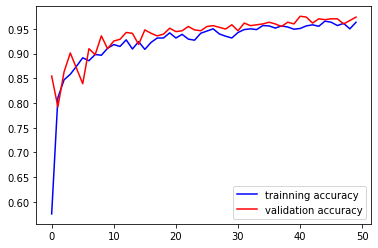

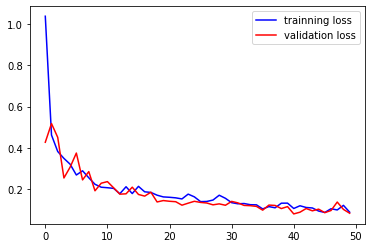

In [57]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [61]:
prediction=model.predict(X_test) 
classes_x=np.argmax(prediction,axis=1)


In [67]:
prediction=classes_x

In [68]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [69]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.93      0.84      0.88        63
     no_yawn       0.88      0.95      0.91        74
      Closed       1.00      0.94      0.97       215
        Open       0.95      1.00      0.97       226

    accuracy                           0.96       578
   macro avg       0.94      0.93      0.93       578
weighted avg       0.96      0.96      0.95       578



In [71]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new7.h5")

In [73]:
prediction = model.predict([prepare(r"../input/yawn-eye-dataset-new/dataset_new/train/Closed/_1.jpg")])
np.argmax(prediction)

2

In [74]:
model.save("finalmode.py")

In [3]:
import tensorflow as tf
cm=tf.math.confusion_matrix(labels=labels_new,predictions=predictions)
cm

plt.figure(figsize=(12,6))
sns.heatmap(cm,annot=True,cmap='plasma',fmt='d')
plt.xlabel('Actual labels')
plt.ylabel('Predictions')

NameError: name 'labels_new' is not defined